# **Question:** How do different cover crop practices affect soil organic carbon (SOC) levels across regions?

# Part 1 - Import libraries and load dataset

In [ ]:
# --- Part 1: Import libraries and load dataset ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from google.colab import drive
import sys, os
from IPython.display import display, Markdown
import warnings
from statsmodels.stats.multicomp import MultiComparison
from matplotlib.patches import Patch


# Mount Google Drive silently
_original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
drive.mount('/content/drive')
sys.stdout.close()
sys.stdout = _original_stdout
print("✅ Google Drive mounted.")

# Load dataset from Google Drive
data_path = "/content/drive/MyDrive/SoilHealthDB_V2.xlsx"
df = pd.read_excel(data_path, sheet_name="Sheet1")

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Overview of the dataset
print(f"✅ Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

✅ Google Drive mounted.
✅ Loaded dataset with 5907 rows and 270 columns.


,studyid,experimentid,author_f,author_g,yearpublication,samplingyear,journal,siteinfor,country,latitude,...,mbn_c_sd,mbn_t_sd,38.mbn_comments,microelement,sqi,ess,texture_c,comments1,comments2,comments3
0,1,1-1,Abawi,G.S.,2000,NaN,Applied Soil Ecology,New York,USA,40.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Root infected by rot,NaN,NaN
1,1,1-1,Abawi,G.S.,2000,NaN,Applied Soil Ecology,New York,USA,40.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Root infected by rot,NaN,NaN
2,1,1-2,Abawi,G.S.,2000,NaN,Applied Soil Ecology,New York,USA,40.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Root infected by rot,NaN,NaN
3,1,1-1,Abawi,G.S.,2000,NaN,Applied Soil Ecology,New York,USA,40.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Root infected by rot,NaN,NaN
4,1,1-4,Abawi,G.S.,2000,NaN,Applied Soil Ecology,New York,USA,40.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Root infected by rot,NaN,NaN


# Part 2 - Filter and prepare relevant data

In [ ]:
# --- Part 2: Filter and prepare relevant data ---

# Verificar valores em falta nas variáveis essenciais
essential_cols = ["covercropgroup", "backgroundsoc", "country"]
missing_check = df[essential_cols].isna().sum()
print("🔍 Valores em falta por coluna:\n", missing_check)

# Selecionar apenas colunas essenciais
columns_to_keep = [
    "covercropgroup",       # Grupo de culturas de cobertura
    "backgroundsoc",        # Carbono orgânico no solo
    "country"               # Localização (proxy regional)
]

# Filtrar linhas com dados completos nessas variáveis
df_soc = df[columns_to_keep].dropna()

# Mostrar visão geral
print(f"✅ Conjunto de dados filtrado com {df_soc.shape[0]} linhas completas.")
df_soc.head()

🔍 Valores em falta por coluna:
 covercropgroup     845
backgroundsoc     3305
country              0
dtype: int64
✅ Conjunto de dados filtrado com 2400 linhas completas.


,covercropgroup,backgroundsoc,country
83,Rye,1.80,USA
84,Rye,1.80,USA
85,Rye,0.94,USA
86,Rye,0.65,USA
87,Rye,0.47,USA


# Part 3 - Descriptive statistics

In [ ]:
# --- Part 3: Descriptive statistics ---

# Generate descriptive statistics of SOC by cover crop group
soc_summary = df_soc.groupby("covercropgroup")["backgroundsoc"].describe()

# Display the results
print("📊 Descriptive statistics of Soil Organic Carbon (SOC) by Cover Crop Group:")
display(soc_summary)

📊 Descriptive statistics of Soil Organic Carbon (SOC) by Cover Crop Group:


,count,mean,std,min,25%,50%,75%,max
covercropgroup,,,,,,,,
AVG,24.0,1.580615,0.843602,0.750000,0.750000,1.567814,1.775581,3.150000
Brassica,69.0,1.684340,0.914464,0.600000,1.000000,1.330000,2.900000,3.200000
Broadleaf,32.0,1.430625,0.555273,0.620000,0.620000,1.800000,1.800000,1.800000
Broadleaf/Brassica,1.0,0.161000,NaN,0.161000,0.161000,0.161000,0.161000,0.161000
Grass,305.0,2.638680,1.384504,0.600000,1.700000,2.490000,2.810000,6.100000
LB,4.0,2.900000,0.000000,2.900000,2.900000,2.900000,2.900000,2.900000
LG,82.0,1.501463,0.603617,0.880000,0.880000,1.650000,1.957500,2.900000
LL,81.0,0.886677,0.150603,0.460000,0.800000,0.900000,0.991111,1.111111
Legume,1478.0,1.320739,0.875769,0.140000,0.740000,1.100000,1.710000,5.600000


,backgroundsoc,duration,soilph
backgroundsoc,1.00,-0.01,0.12
duration,-0.01,1.00,0.21
soilph,0.12,0.21,1.00


<br><br>

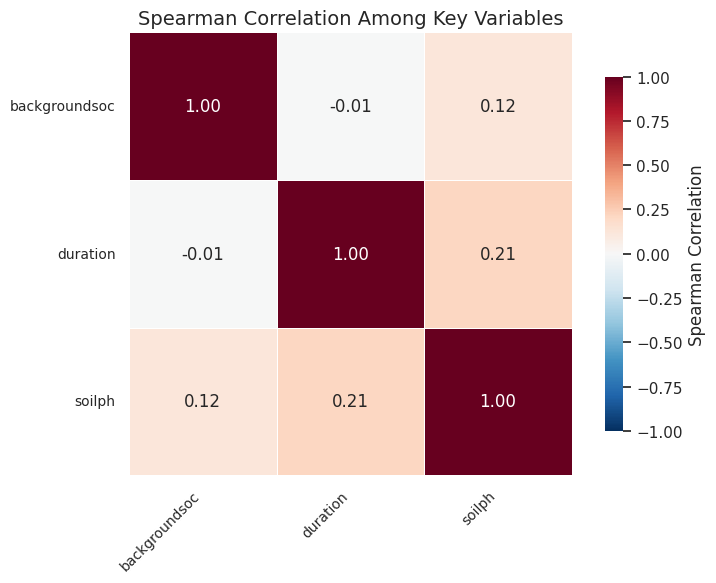

In [ ]:
# Exploratory Correlation Analysis

# Variables for correlation
cor_vars = ["backgroundsoc", "duration", "soilph"]

# Compute Spearman correlation matrix
corr_matrix = df[cor_vars].corr(method="spearman")

# Display styled table
styled_corr = corr_matrix.style\
    .background_gradient(cmap="RdBu_r", vmin=-1, vmax=1)\
    .format("{:.2f}")\
    .set_caption("Spearman Correlation Matrix Among Key Variables")\
    .set_properties(**{"text-align": "center"})

display(styled_corr)

# Add vertical space before plot
display(Markdown("<br><br>"))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    linewidths=0.5,
    linecolor='white',
    square=True,
    vmin=-1, vmax=1,
    cbar_kws={"shrink": 0.8, "label": "Spearman Correlation"}
)
plt.title("Spearman Correlation Among Key Variables", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()



# Part 4 - Data visualization

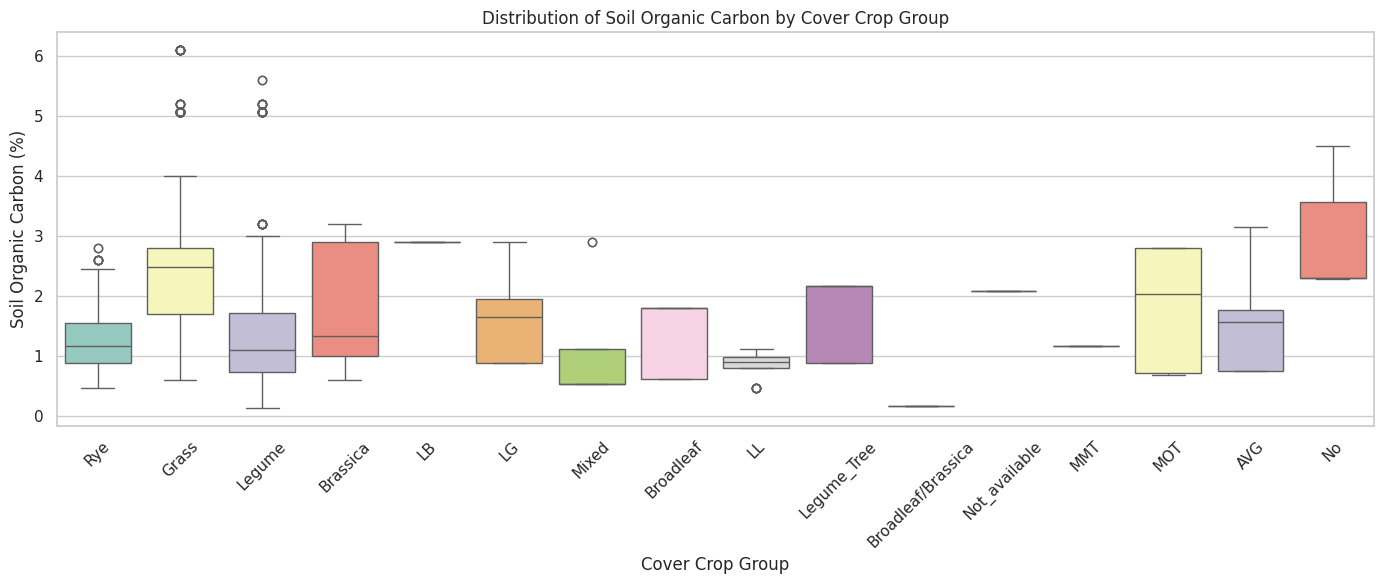

In [ ]:
# --- Part 4: Data Visualization ---

# Set Seaborn style
sns.set(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Create colored boxplot using hue and palette (with no legend)
sns.boxplot(
    data=df_soc,
    x="covercropgroup",
    y="backgroundsoc",
    hue="covercropgroup",
    palette="Set3",
    legend=False,
    ax=ax
)

# Improve label readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Cover Crop Group")
ax.set_ylabel("Soil Organic Carbon (%)")
ax.set_title("Distribution of Soil Organic Carbon by Cover Crop Group")

# Layout adjustment
plt.tight_layout()
plt.show()

🌍 Unique countries in dataset (25 total):
['Usa' 'Canada' 'Brazil' 'Nigeria' 'Argentina' 'Denmark' 'Australia'
 'Ghana' 'Malawi' 'Zambia' 'Uganda' 'Kenya' 'Zimbabwe' 'Cameroon'
 'Tanzania' 'Togo' 'China' 'France' 'South Korea' 'Turkey' 'Spain'
 'England' 'Italy' 'Germany' 'Indonesia']

📊 Top countries by number of observations:
country
China       497
Usa         415
Zambia      380
Nigeria     357
Malawi      180
Kenya       100
Uganda       96
Spain        50
Tanzania     43
Turkey       41
Denmark      41
Togo         40
Zimbabwe     33
Ghana        20
Cameroon     16
Name: count, dtype: int64


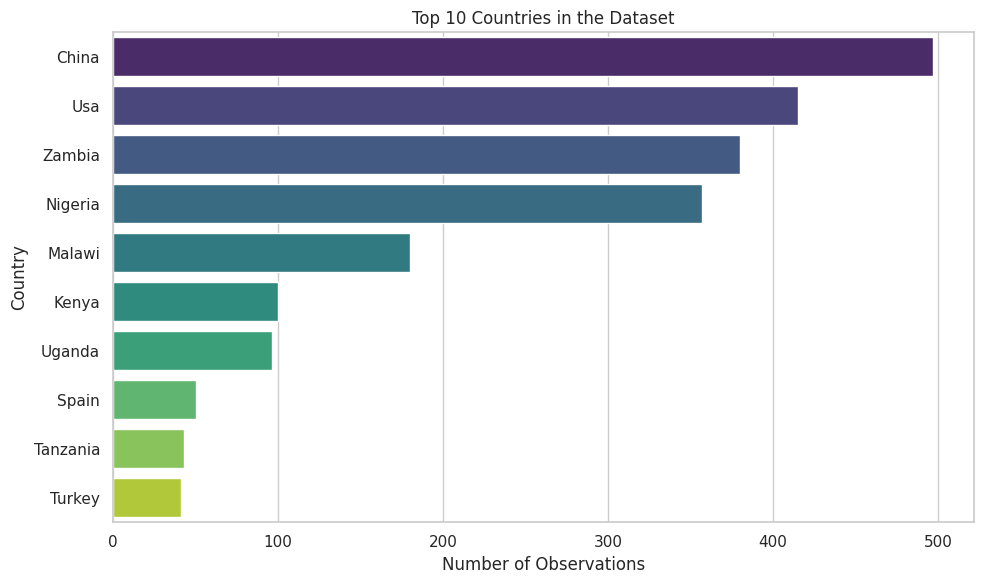

In [ ]:
# --- Country Verification and Frequency Analysis ---

import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Normalize country names (strip spaces, standardize capitalization)
df_soc["country"] = df_soc["country"].astype(str).str.strip().str.title()

# Step 2: Show all unique countries (to inspect for typos or inconsistencies)
unique_countries = df_soc["country"].unique()
print(f"🌍 Unique countries in dataset ({len(unique_countries)} total):")
print(unique_countries)

# Step 3: Count occurrences of each country
country_counts = df_soc["country"].value_counts()
print("\n📊 Top countries by number of observations:")
print(country_counts.head(15))  # Adjust as needed

# Step 4: Optional visualization of top N countries
plt.figure(figsize=(10, 6))
sns.barplot(
    x=country_counts.head(10).values,
    y=country_counts.head(10).index,
    palette="viridis"
)
plt.xlabel("Number of Observations")
plt.ylabel("Country")
plt.title("Top 10 Countries in the Dataset")
plt.tight_layout()
plt.show()


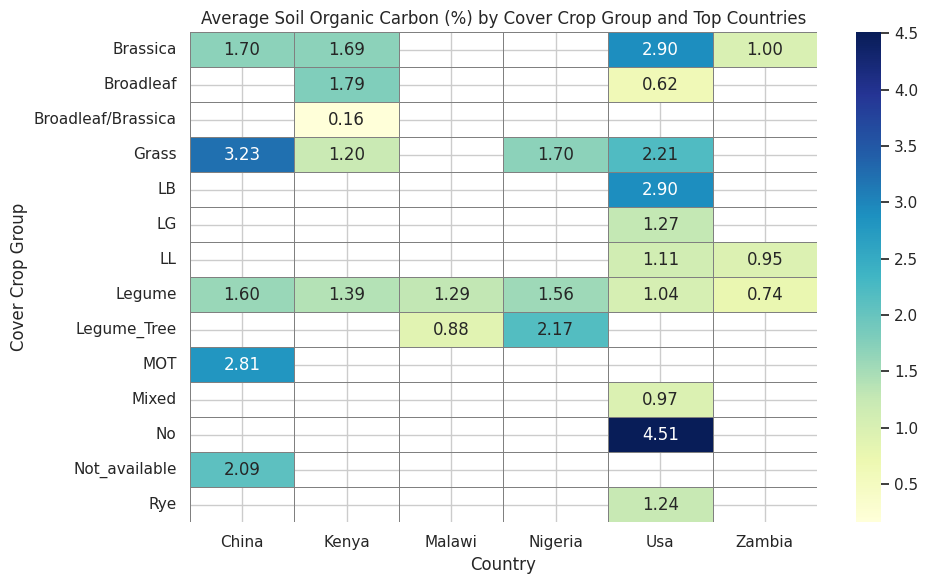

In [ ]:
# --- SOC Mean Heatmap by Cover Crop Group and Country ---

# Identify top 6 countries with the most data
top_countries = df_soc["country"].value_counts().head(6).index.tolist()
df_top = df_soc[df_soc["country"].isin(top_countries)]

# Create pivot table: mean SOC per group and country
pivot_df = df_top.groupby(["covercropgroup", "country"])["backgroundsoc"].mean().unstack()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_df,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Average Soil Organic Carbon (%) by Cover Crop Group and Top Countries")
plt.ylabel("Cover Crop Group")
plt.xlabel("Country")
plt.tight_layout()
plt.show()


/tmp/ipython-input-78-1498394457.py:18: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  g = sns.catplot(


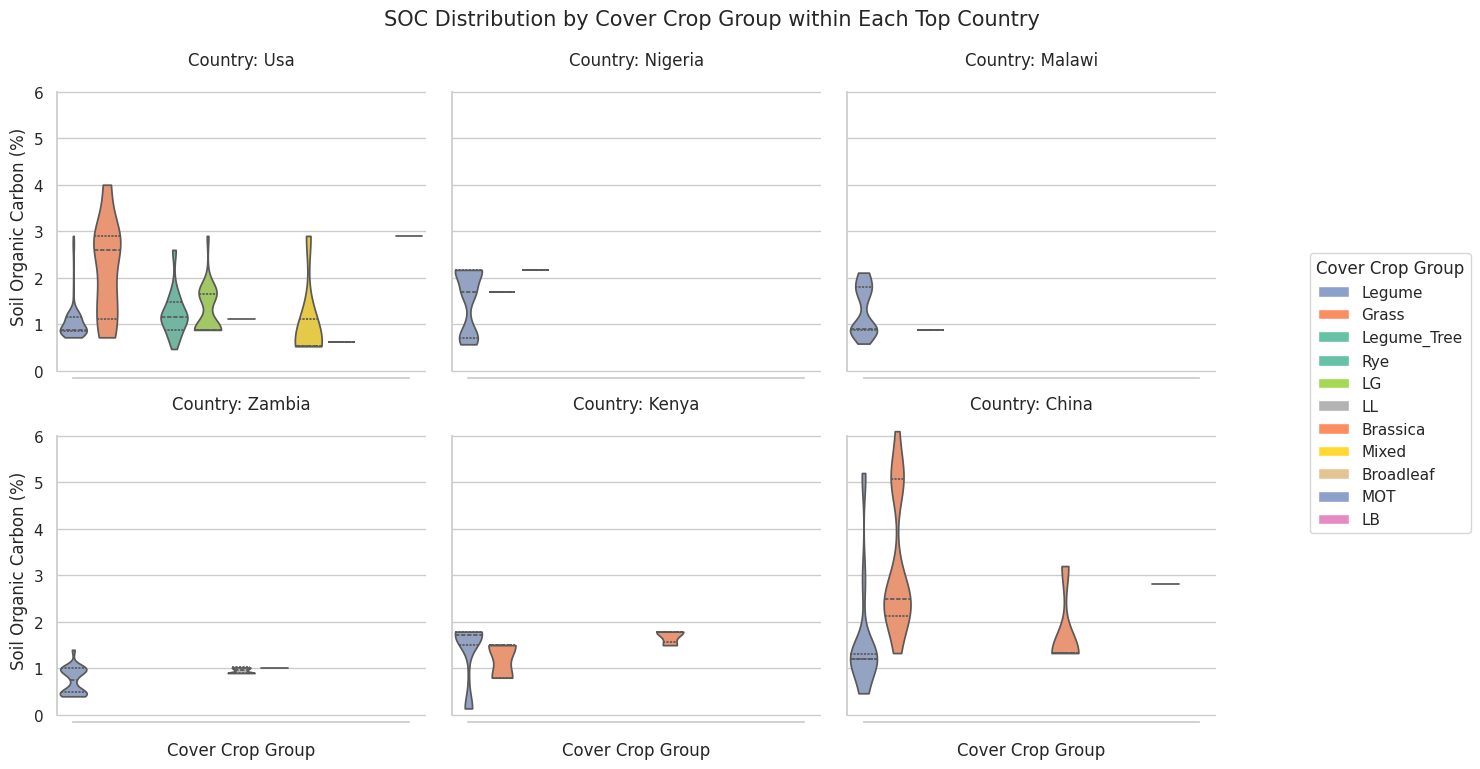

In [ ]:
# --- SOC Distribution by Cover Crop Group Within Each Top Country (Violin Plot) ---

# Seleção dos top países
top_countries = df_soc["country"].value_counts().head(6).index.tolist()
df_top = df_soc[df_soc["country"].isin(top_countries)]

# Filtrar combinações válidas (mín. 3 observações)
group_counts = df_top.groupby(["country", "covercropgroup"]).size().reset_index(name="n")
valid_groups = group_counts[group_counts["n"] >= 3][["country", "covercropgroup"]]
df_filtered = df_top.merge(valid_groups, on=["country", "covercropgroup"], how="inner")

# Paleta e ordem
group_order = df_filtered["covercropgroup"].value_counts().index.tolist()
unique_groups = df_filtered["covercropgroup"].unique()
palette = dict(zip(unique_groups, sns.color_palette("Set2", len(unique_groups))))

# Criar gráfico de violin plots
g = sns.catplot(
    data=df_filtered,
    x="covercropgroup",
    y="backgroundsoc",
    col="country",
    hue="covercropgroup",
    kind="violin",
    col_wrap=3,
    height=4,
    aspect=1.2,
    palette=palette,
    legend=False,
    order=group_order,
    cut=0,               # cortar na gama dos dados
    inner="quartile",    # mostra linhas de quartis dentro dos violinos
    scale="area"         # tamanhos proporcionais à densidade
)

# Ajustes visuais
g.set_titles("Country: {col_name}")
g.set_axis_labels("Cover Crop Group", "Soil Organic Carbon (%)")
g.set_xticklabels(rotation=45, ha="right")
g.fig.subplots_adjust(top=0.9, right=0.85)
g.fig.suptitle("SOC Distribution by Cover Crop Group within Each Top Country", fontsize=15)

# Legenda manual
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=palette[group], label=group) for group in group_order]
g.fig.legend(
    handles=legend_patches,
    title="Cover Crop Group",
    loc="center left",
    bbox_to_anchor=(0.91, 0.5),
    frameon=True
)

sns.despine(trim=True)
plt.show()



# Part 5 - Inferential Statistics

In [ ]:
# --- Part 5: Inferential Statistics ---

# Log transformation to normalize SOC
df_soc["log_soc"] = np.log1p(df_soc["backgroundsoc"])

# Disable scipy warning for zero variance in Shapiro test
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.stats")

# Shapiro-Wilk normality test per group (filtered)
def safe_shapiro(x):
    if len(x) >= 3 and np.var(x) > 0:
        try:
            return stats.shapiro(x)
        except:
            return (None, None)
    else:
        return (None, None)

normality_results = df_soc.groupby("covercropgroup")["backgroundsoc"].apply(safe_shapiro)

# Format results
normality_df = (
    pd.DataFrame(normality_results.tolist(),
                 index=normality_results.index,
                 columns=["W (Shapiro)", "p-value"])
    .dropna()
    .sort_values("p-value")
)

# One-way ANOVA
model = ols('backgroundsoc ~ C(covercropgroup)', data=df_soc).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_display = anova_table.copy()
anova_display.columns = ["Sum of Squares", "df", "F-Value", "p-Value"]

# Display results
display(Markdown("### 🧪 Shapiro-Wilk Normality Test per Cover Crop Group"))
display(normality_df.style
        .format({"W (Shapiro)": "{:.3f}", "p-value": "{:.2e}"})
        .background_gradient(cmap="Oranges", subset=["p-value"])
        .set_caption("Normality test sorted by p-value"))

display(Markdown("### 📈 One-way ANOVA Table"))
display(anova_display.style
        .format({"Sum of Squares": "{:.2f}", "F-Value": "{:.2f}", "p-Value": "{:.2e}"})
        .highlight_max(axis=0, color='lightgreen')
        .set_caption("Effect of Cover Crop Group on SOC"))


### 🧪 Shapiro-Wilk Normality Test per Cover Crop Group

,W (Shapiro),p-value
covercropgroup,,
Legume,0.833,8.91e-37
Legume_Tree,0.601,2.57e-18
Grass,0.859,5.26e-16
Brassica,0.767,4.15e-09
LL,0.821,1.73e-08
Rye,0.874,2.31e-08
Broadleaf,0.586,2.54e-08
LG,0.832,3.21e-08
Mixed,0.599,1.59e-05


### 📈 One-way ANOVA Table

,Sum of Squares,df,F-Value,p-Value
C(covercropgroup),533.11,15.000000,43.45,1.92e-113
Residual,1949.98,2384.000000,nan,nan


# Part 6 - Post-hoc and Non-parametric Analysis

In [ ]:
# --- Part 6: Post-hoc and Advanced Analysis ---

# Kruskal-Wallis Test (non-parametric alternative to ANOVA)
kruskal_result = kruskal(
    *[group["backgroundsoc"].values for name, group in df_soc.groupby("covercropgroup")]
)
print(f"📌 Kruskal-Wallis H-test: H = {kruskal_result.statistic:.2f}, p = {kruskal_result.pvalue:.2e}")

📌 Kruskal-Wallis H-test: H = 431.49, p = 1.64e-82


In [ ]:
# Tukey HSD Test for post-hoc comparisons
mc = MultiComparison(df_soc["backgroundsoc"], df_soc["covercropgroup"])
tukey_result = mc.tukeyhsd()
tukey_summary = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
tukey_summary.sort_values("p-adj", inplace=True)

# Show significant results only
significant_pairs = tukey_summary[tukey_summary["reject"] == True]
print("📊 Significant pairwise differences (Tukey HSD):")
display(significant_pairs)


📊 Significant pairwise differences (Tukey HSD):


,group1,group2,meandiff,p-adj,lower,upper,reject
3,AVG,Grass,1.0581,0.0000,0.4005,1.7157,True
30,Broadleaf,Grass,1.2081,0.0000,0.6317,1.7844,True
20,Brassica,LL,-0.7977,0.0000,-1.3058,-0.2895,True
17,Brassica,Grass,0.9543,0.0000,0.5408,1.3678,True
59,Grass,MMT,-1.4787,0.0000,-2.3916,-0.5658,True
56,Grass,LL,-1.7520,0.0000,-2.1397,-1.3643,True
57,Grass,Legume,-1.3179,0.0000,-1.5130,-1.1229,True
39,Broadleaf,No,1.4886,0.0000,0.4946,2.4825,True
55,Grass,LG,-1.1372,0.0000,-1.5231,-0.7514,True
58,Grass,Legume_Tree,-0.9162,0.0000,-1.2277,-0.6048,True


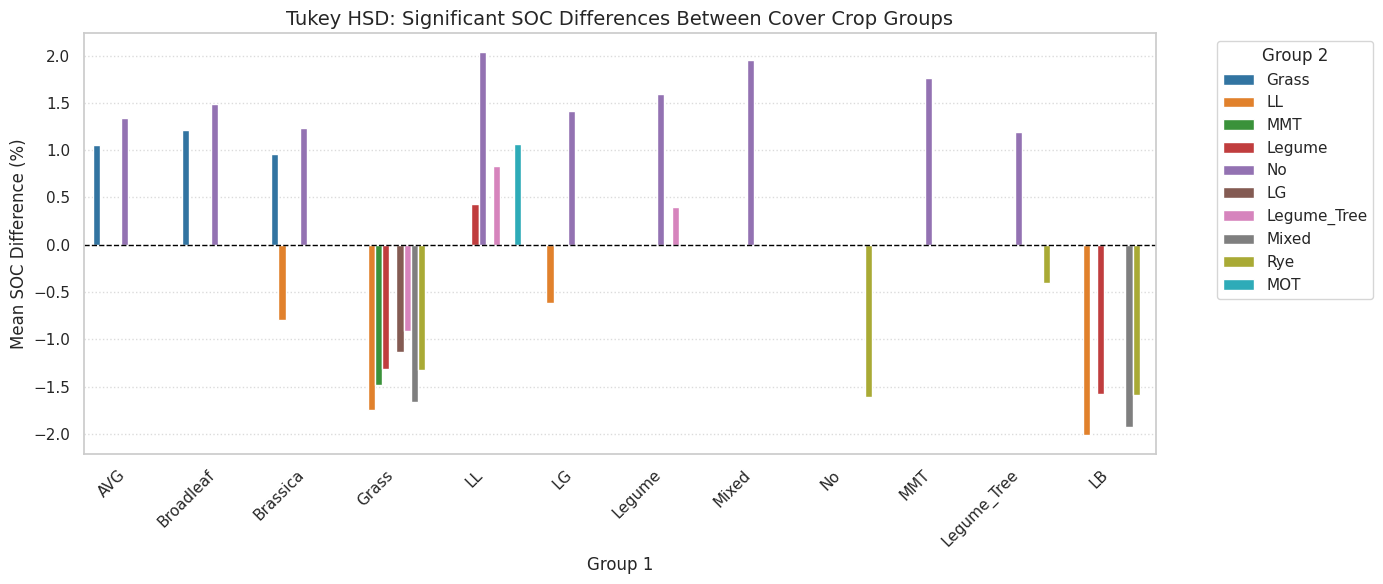

In [ ]:
# Plot significant differences
plt.figure(figsize=(14, 6))
sns.barplot(
    data=significant_pairs,
    x="group1",
    y="meandiff",
    hue="group2",
    dodge=True,
    palette="tab10"
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Group 1", fontsize=12)
plt.ylabel("Mean SOC Difference (%)", fontsize=12)
plt.title("Tukey HSD: Significant SOC Differences Between Cover Crop Groups", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Group 2", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()